## Data Colection

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import difflib
import time

In [2]:
transfer_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/transfers/wettbewerb/GB1",
                "Bundesliga":   "http://www.transfermarkt.es/bundesliga/transfers/wettbewerb/L1",
                "Serie A":      "http://www.transfermarkt.es/serie-a/transfers/wettbewerb/IT1",
                "Ligue 1":      "http://www.transfermarkt.es/ligue-1/transfers/wettbewerb/FR1",
                "La Liga":      "http://www.transfermarkt.es/primera-division/transfers/wettbewerb/ES1",
}


liga_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/startseite/wettbewerb/GB1",
            "Bundesliga":   "http://www.transfermarkt.es/bundesliga/startseite/wettbewerb/L1",
            "Serie A":      "http://www.transfermarkt.es/serie-a/startseite/wettbewerb/IT1",
            "Ligue 1":      "http://www.transfermarkt.es/ligue-1/startseite/wettbewerb/FR1",
            "La Liga":      "http://www.transfermarkt.es/laliga/startseite/wettbewerb/ES1",
}

In [31]:
transfer_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/transfers/wettbewerb/GB1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "Bundesliga":   "http://www.transfermarkt.es/bundesliga/transfers/wettbewerb/L1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "Serie A":      "http://www.transfermarkt.es/serie-a/transfers/wettbewerb/IT1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "Ligue 1":      "http://www.transfermarkt.es/ligue-1/transfers/wettbewerb/FR1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "La Liga":      "http://www.transfermarkt.es/primera-division/transfers/wettbewerb/ES1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                }


liga_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2023",
            "Bundesliga":   "http://www.transfermarkt.es/bundesliga/startseite/wettbewerb/L1/?saison_id=2023",
            "Serie A":      "http://www.transfermarkt.es/serie-a/startseite/wettbewerb/IT1/?saison_id=2023",
            "Ligue 1":      "http://www.transfermarkt.es/ligue-1/startseite/wettbewerb/FR1/?saison_id=2023",
            "La Liga":      "http://www.transfermarkt.es/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2023",
            }

In [32]:
df = pd.DataFrame(columns = ["target", "source", "Coste", "player"])

for liga in transfer_urls.keys():

    r = requests.get(liga_urls[liga],
                    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    read_html_pandas_data = pd.read_html(r.text)

    for i in range(len(read_html_pandas_data)):
        try:
            teams_short = read_html_pandas_data[i]["Club.1"].to_list()
            teams_short.sort()

        except:
            pass

    time.sleep(2)

    r = requests.get(transfer_urls[liga],
                    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    read_html_pandas_data = pd.read_html(r.text)

    soup = BeautifulSoup(r.text, "lxml")
    clubs =  soup.find_all("h2")

    clubs_list = []

    for club in clubs:
        try:
            club_name = difflib.get_close_matches(str(club.a.img).split('"')[1], 
                                                teams_short, 
                                                n=1 ,
                                                cutoff=0.45
                                                )[0]
            
            if club_name not in clubs_list:
                clubs_list.append(club_name)
        except:
            pass


    for i, club in enumerate(clubs_list):

        df_in = read_html_pandas_data[2*i +1]
        df_in.rename(columns={"Último club.1": "source", "Altas": "player"}, inplace= True)
        df_in["target"] = club

        df_out = read_html_pandas_data[2*i +2]
        df_out.rename(columns={"Nuevo club.1": "target",  "Bajas": "player"}, inplace= True)
        df_out["source"] = club

        df = pd.concat([df,df_in[["target", "source", "Coste", "player"]]])
        df = pd.concat([df,df_out[["target", "source", "Coste", "player"]]])

df



,target,source,Coste,player
0,Arsenal,West Ham,"116,60 mill. €",Declan RiceD. Rice
1,Arsenal,Chelsea,"75,00 mill. €",Kai HavertzK. Havertz
2,Arsenal,Ajax,"40,00 mill. €",Jurrien TimberJ. Timber
3,Arsenal,Brentford,"Coste de cesión: 3,50 mill. €",David RayaD. Raya
4,Arsenal,Monza,Fin de cesión 30/06/2023,Pablo MaríP. Marí
...,...,...,...,...
14,Real Sociedad,Alavés,Fin de cesión 31/12/2023,Jon KarrikaburuJ. Karrikaburu
15,Liverpool U21,Alavés,Fin de cesión 30/06/2023,Anderson ArroyoA. Arroyo
16,Real Betis,Alavés,Fin de cesión 30/06/2023,Rober GonzálezR. González
17,UD Almería,Alavés,Fin de cesión 30/06/2023,Nikola MarasN. Maras


In [34]:
df.to_csv("transfers_2023.csv", index= False)

## cleaning

In [35]:
df = pd.read_csv("transfers_2023.csv")

In [36]:
df = df.drop_duplicates()
df = df[df["target"] != "Retirado"]
df = df[df["Coste"].str[:13] != "Fin de cesión"]
df = df[df["target"] != "Sin equipo"]
df = df[df["source"] != "Sin equipo"]

In [37]:
df_transfer = df[["target", "source", "player"]].groupby(["target", "source"]).count().reset_index()
df_transfer.rename(columns = {"player": "value"}, inplace = True)

In [38]:
df_transfer

,target,source,value
0,1.FC K'lautern,Colonia,1
1,1.FC K'lautern,Darmstadt 98,2
2,1.FC K'lautern,Eintracht,1
3,1.FC K'lautern,Unión Berlín,1
4,1.FC Magdeburg,Inter,1
...,...,...,...
2227,Yverdon Sport,Lazio,1
2228,Z. Sosnowiec,Brentford,1
2229,inactivo,FC Augsburgo,1
2230,ŁKS,Marsella,1


## network

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

from pyvis.network import Network
import community as community_louvain

In [40]:
G = nx.from_pandas_edgelist(df_transfer,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph(),
                            )

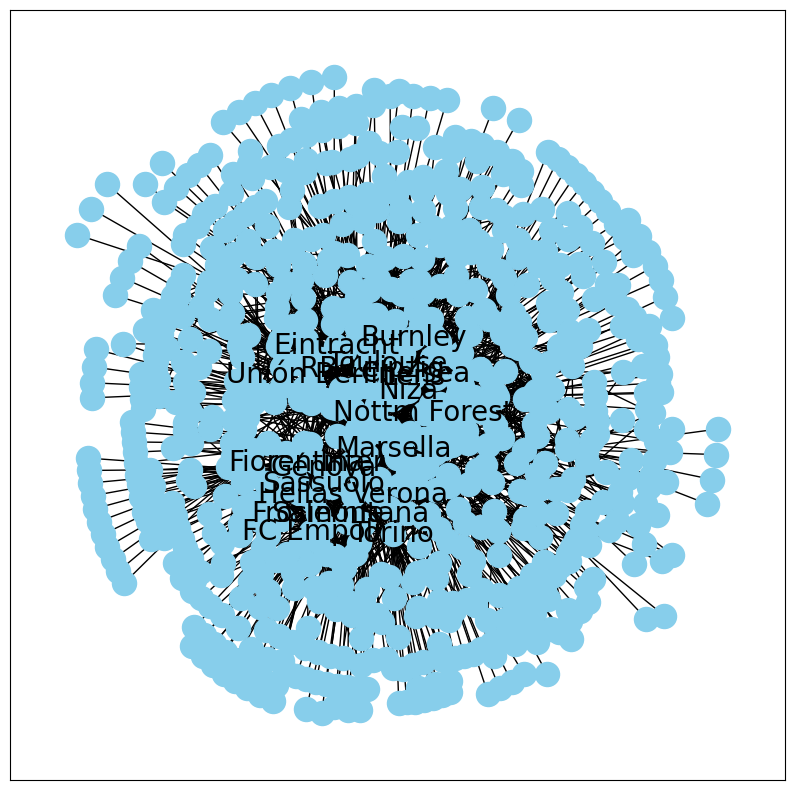

In [41]:
plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G)

node_degree = dict(G.degree)
nx.draw_networkx(G, with_labels = False, node_color = "skyblue", edge_cmap = plt.cm.Blues, pos = pos)

sorted_nodes = sorted(node_degree.items(), key=lambda x:x[1], reverse=True)
labels_dict = dict(sorted_nodes[:19])

big_teams=[]
for node in labels_dict.items():
    big_teams.append(node[0])
big_teams

pos_large = {k: v for k, v in pos.items() if k in big_teams}


nx.draw_networkx_labels(G.subgraph(big_teams), pos_large, font_size=20)
 
plt.show()

## visualization

In [42]:
net = Network(notebook = False, width ="1000px", height = "720px", bgcolor = "#222222", font_color = "white")

node_degree = dict(G.degree) ###### revisar
centrality_dict = nx.degree_centrality(G)
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)

#Community detection

communities = nx.community.louvain_communities(G)   
community_dict = {}
for group_id, community in enumerate(communities):
    for node in community:
        community_dict[node] = group_id

#set attributes

nx.set_node_attributes(G, node_degree, "size")
nx.set_node_attributes(G, centrality_dict, "degree_centrality")
nx.set_node_attributes(G, closeness_dict, "closeness_centrality")
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")
nx.set_node_attributes(G, community_dict, "group")

net.repulsion()

net.from_nx(G)
net.show("transfer.html")